In [1]:
# ---------- IMPORTS AND FUNCTIONS ---------- #

import numpy as np
import matplotlib.pyplot as plt
import pint
from matplotlib import rcParams

# Set Times New Roman as the default font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'  # Computer Modern for math symbols
plt.rcParams['font.size'] = 12  # Base font size
plt.rcParams['axes.labelsize'] = 14  # Font size for axis labels
plt.rcParams['axes.titlesize'] = 14  # Font size for titles
plt.rcParams['xtick.labelsize'] = 12  # Font size for tick labels
plt.rcParams['ytick.labelsize'] = 12  # Font size for tick labels
plt.rcParams['legend.fontsize'] = 12  # Font size for legends

# Unit registry
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

# Functions

def average_temp(T_hot, T_cold):
    return Q_((T_hot.magnitude + T_cold.magnitude)/2, 'degC')

def salt_density_plotter(T_plot, rho, T_hot, T_cold):

    T_avg = average_temp(T_hot, T_cold)

    plt.figure(figsize=(8, 6))  # Make the plot a bit larger
    plt.plot(T_plot.magnitude, rho.magnitude, label='Density', linewidth=2, color='blue')
    
    # Add vertical lines at 700°C and 570°C
    plt.axvline(x=T_hot.magnitude, color='r', linestyle='--', alpha=0.5, label=f'T = {T_hot.magnitude} {T_hot.units:~} (hot leg)')
    plt.axvline(x=T_cold.magnitude, color='b', linestyle='--', alpha=0.5, label=f'T = {T_cold.magnitude} {T_cold.units:~} (cold leg)')
    plt.axvline(x=T_avg.magnitude, color='magenta', linestyle='--', alpha=0.5, label=f'T =  {T_avg.magnitude} {T_avg.units:~} ')


    plt.xlabel('T [°C]')
    plt.ylabel(r"$\rho$ [g/cm³]")
    plt.title(f'Density curve of NaCl-MgCl2 eutectic', fontsize=16)
    plt.grid(True)  # Add grid for better readability
    plt.legend()  # Show the legend

def crucible_volume(z_salt, r_salt, output_unit='cm^3'):
    """
    Input:
    z_salt: height of salt in mm
    r_salt: radius of salt in mm
    output_unit: desired output unit (default is cm³), write w. ^3 for cubic units
    
    Output:
    V_salt: Volume of salt in desired unit
    """
    
    z_salt_param = Q_(z_salt, 'mm')
    r_salt_param = Q_(r_salt, 'mm')
    V_salt = np.pi * r_salt_param**2 * z_salt_param  # will automatically be in mm³

    return V_salt.to(output_unit)  # convert to cm³

def salt_mass_crucible(T_salt, type, z_salt=75, r_salt=7):
    """
    Input:
    T_salt: Temperature of the salt in degC
    type: "eutectic" or "mimosa"
    z_salt: height of salt in crucible in mm (default 75 mm)
    r_salt: radius of salt in crucible in mm (default 7 mm)
    
    Output:
    m_salt = Mass of salt in grams
    """
    T = Q_(T_salt, 'degC').to('K')  # convert to K and store the converted value
    V_salt = crucible_volume(z_salt, r_salt, 'cm^3')  # volume of salt in crucible in cm³
    
    # Density coefficients NaCl-MgCl2 eutectic and MIMOSA salt
    a = globals()["a"]
    a = Q_(a.magnitude, a.units).to('g/cm^3')   # ensure correct units
    b = globals()["b"]
    b = Q_(b.magnitude, b.units).to('g/(cm^3*K)')  # ensure correct units
    rho_mimosa_600C = globals()["rho_mimosa_600C"]
    rho_mimosa_600C = Q_(rho_mimosa_600C.magnitude, rho_mimosa_600C.units).to('g/cm^3')  # ensure correct units
    rho_mimosa_700C = globals()["rho_mimosa_700C"]
    rho_mimosa_700C = Q_(rho_mimosa_700C.magnitude, rho_mimosa_700C.units).to('g/cm^3')  # ensure correct units
    
    # MIMOSA salt fractions w%
    nacl_mimosa_wfrac = globals()["nacl_mimosa_wfrac"]
    mgcl2_mimosa_wfrac = globals()["mgcl2_mimosa_wfrac"]
    cecl3_mimosa_wfrac = globals()["cecl3_mimosa_wfrac"]

    # NaCl-MgCl2 eutectic fractions w%
    nacl_eut_wfrac = globals()["nacl_eut_wfrac"]
    mgcl2_eut_wfrac = globals()["mgcl2_eut_wfrac"]

    # MIMOSA salt fractions m%
    nacl_mimosa_mfrac = globals()["nacl_mimosa_mfrac"]
    mgcl2_mimosa_mfrac = globals()["mgcl2_mimosa_mfrac"]
    cecl3_mimosa_mfrac = globals()["cecl3_mimosa_mfrac"]

    # NaCl-MgCl2 eutectic fractions m%
    nacl_eut_mfrac = globals()["nacl_eut_mfrac"]
    mgcl2_eut_mfrac = globals()["mgcl2_eut_mfrac"]


    if type == "eutectic":
        if nacl_eut_mfrac != 0 and mgcl2_eut_mfrac != 0 and nacl_eut_wfrac != 0 and mgcl2_eut_wfrac != 0:
            # Chose which one you wanna use:
            input_choice = input("Both mass and molar fractions are defined. Type 'm' to use molar fractions or 'w' to use mass fractions: ")
            if input_choice.lower() == 'w':
                print("Using eutectic mass fractions to composition.")
                
                rho_salt = a - b*T  # g/cm³ at T
                m_salt = rho_salt * V_salt  # converting volume to cm³ to match density units
                
                # Create the arrays separately for eutectic
                names = ["NaCl", "MgCl2"]
                masses = [nacl_eut_wfrac*m_salt.magnitude, mgcl2_eut_wfrac*m_salt.magnitude]

                molar_fractions = molar_fraction(names, masses)
                mass_fractions = mass_fraction(names, molar_fractions)

            elif input_choice.lower() == 'm':
                print("Using eutectic molar fractions to composition.")
                
                rho_salt = a - b*T  # g/cm³ at T
                m_salt = rho_salt * V_salt  # converting volume to cm³ to match density units
                
                # Create the arrays separately for eutectic
                names = ["NaCl", "MgCl2"]
                salt_molarfrac = [nacl_eut_mfrac, mgcl2_eut_mfrac]

                mass_fractions = mass_fraction(names, salt_molarfrac)
                molar_fractions = molar_fraction(names, mass_fractions)

        if nacl_eut_mfrac == 0 and mgcl2_eut_mfrac == 0 and nacl_eut_wfrac != 0 and mgcl2_eut_wfrac != 0:
            print("Using eutectic mass fractions to composition.")
            
            rho_salt = a - b*T  # g/cm³ at T
            m_salt = rho_salt * V_salt  # converting volume to cm³ to match density units
            
            # Create the arrays separately for eutectic
            names = ["NaCl", "MgCl2"]
            masses = [nacl_eut_wfrac*m_salt.magnitude, mgcl2_eut_wfrac*m_salt.magnitude]

            molar_fractions = molar_fraction(names, masses)

        elif nacl_eut_wfrac == 0 and mgcl2_eut_wfrac == 0 and nacl_eut_mfrac != 0 and mgcl2_eut_mfrac != 0:
            print("Using eutectic molar fractions to composition.")
            
            rho_salt = a - b*T  # g/cm³ at T
            m_salt = rho_salt * V_salt  # converting volume to cm³ to match density units
            
            # Create the arrays separately for eutectic
            names = ["NaCl", "MgCl2"]
            salt_molarfrac = [nacl_eut_mfrac, mgcl2_eut_mfrac]

            mass_fractions = mass_fraction(names, salt_molarfrac)

        elif nacl_eut_mfrac == 0 and mgcl2_eut_mfrac == 0 and nacl_eut_wfrac == 0 and mgcl2_eut_wfrac == 0:
            raise ValueError("Error: No fractions defined.")
        
        
        

    elif type == "mimosa":  # Changed if to elif
        if T_salt == 600:
            rho_salt = rho_mimosa_600C
            m_salt = rho_salt * V_salt
        elif T_salt == 700:  # Changed if to elif
            rho_salt = rho_mimosa_700C
            m_salt = rho_salt * V_salt
        else:
            alpha = (rho_mimosa_700C - rho_mimosa_600C) / (700 - 600)
            beta = rho_mimosa_600C + alpha * 600
            rho_salt = beta - alpha * T_salt
            m_salt = rho_salt * V_salt
        
        # Create the arrays separately for mimosa
        names = ["NaCl", "MgCl2", "CeCl3"]
        masses = [nacl_mimosa_wfrac*m_salt.magnitude, mgcl2_mimosa_wfrac*
                  m_salt.magnitude, cecl3_mimosa_wfrac*m_salt.magnitude]
        molar_fractions = molar_fraction(names, masses)

    else:
        raise ValueError("Unknown salt type. Must be 'eutectic' or 'mimosa'")

    print(mass_fractions)
    print(molar_fractions)

    
    print("--------------------------------------------------")
    print("\nSALT LOADING QUANTITIES FOR CRUCIBLE:")
    print(f"Type: {type}")
    print(f"Weight fractions (w%):")
    for name, mass in zip(names, masses):
        print(f"\u00b7 {name} = {mass_fractions[names.index(name)]}%")
    
    print(f"Molar fractions (m%): ")
    for name, mass in zip(names, masses):
        print(f"\u00b7 {name} = {molar_fractions[names.index(name)]:.2f}%")
        
    print(f"Salt temperature: {T.magnitude} K, {T.to('degC').magnitude} °C")
    print(f"Density at temperature: {rho_salt}")
    print(f"Mass of salt mixture: {m_salt.to('g'):.2f~P}")
    print("Mass of components:")
    for name, mass in zip(names, masses):
        print(f"\u00b7 {name}: {mass:.2f} g")

    # Convert to numpy arrays before returning
    return m_salt, np.array(names), np.array(masses)


def molar_fraction(salt_names, salt_masses):
    """
    Input:
    salt_names: array of salt names
    salt_masses: array of salt masses in grams
    
    Output:
    molar_fractions: array of molar fractions in percentage
    """
    molar_masses_dict = []
    for i in salt_names:
        salt_molar_mass = globals()[f"{i.lower()}_molar_mass"]
        salt_molar_mass = Q_(salt_molar_mass.magnitude, salt_molar_mass.units).to('g/mol')  # ensure correct units  
        molar_masses_dict.append(salt_molar_mass)
    molar_masses_dict = dict(zip(salt_names, molar_masses_dict))
    
    moles = []
    for name, mass in zip(salt_names, salt_masses):
        molar_mass = molar_masses_dict.get(name).magnitude
        if molar_mass is None:
            raise ValueError(f"Unknown salt name: {name}")
        moles.append(mass / molar_mass)
    
    moles = np.array(moles)
    total_moles = np.sum(moles)
    
    # Calculate molar fractions in percentage
    molar_fractions = (moles / total_moles) * 100
    
    return molar_fractions

def mass_fraction(salt_names, salt_molarfrac):
    """
    Input:
    salt_names: array of salt names
    salt_masses: array of salt molar fractions
    
    Output:
    mass_fractions: array of mass fractions in percentage
    """
    mass_frac = []
    for i in salt_names:
        salt_molar_mass = globals()[f"{i.lower()}_molar_mass"]
        salt_molar_mass = Q_(salt_molar_mass.magnitude, salt_molar_mass.units).to('g/mol')  # ensure correct units  
        
        n_mass_fraction = (salt_molar_mass * salt_molarfrac[salt_names.index(i)])  # g/mol * molar fraction

        mass_frac.append(n_mass_fraction.magnitude)

    mass_frac = np.array(mass_frac)
    total_mass = np.sum(mass_frac)

    mass_fractions = (mass_frac / total_mass) * 100

    
    return mass_fractions

In [8]:
mass_fraction(["NaCl","MgCl2", "CeCl3"], [0.5676,0.3516,0.0808])

array([38.3199993 , 38.67268538, 23.00731531])

In [9]:
# ---------- CONSTANTS AND THERMODYNAMIC PARAMETERS ---------- #

# Density coefficients of NaCl-MgCl2 Eutectic data
a = Q_(2.13, 'g/cm^3')
b = Q_(4.74*10**(-4), 'g/(cm^3*K)')

# Density data of MIMOSA salt
rho_mimosa_600C = Q_(2.53, 'g/cm^3') # at 600C
rho_mimosa_700C = Q_(2.47, 'g/cm^3') # at 700C

# Define temperature range
T = Q_(np.linspace(300, 1000, 100), 'degC')

# Density function
rho = a*np.ones(len(T)) - b*T.to('K')

# Molar masses of components, name in small letters and unit in g/mol
nacl_molar_mass = Q_(58.44, 'g/mol')
mgcl2_molar_mass = Q_(95.21, 'g/mol')
cecl3_molar_mass = Q_(246.48, 'g/mol')

# ---------- SALT FRACTIONS AND TEMPERATURES ---------- #
# One can define either w%, m% or both. The function salt_mass_crucible 
# uses one of them depending on what is defined. 

# MIMOSA salt fractions w%
nacl_mimosa_wfrac = 0.38321
mgcl2_mimosa_wfrac = 0.38672
cecl3_mimosa_wfrac = 0.23006

# NaCl-MgCl2 eutectic fractions w%
nacl_eut_wfrac = 0.38
mgcl2_eut_wfrac = 0.62


# MIMOSA salt fractions m%
nacl_mimosa_mfrac = 42.0
mgcl2_mimosa_mfrac = 40.0
cecl3_mimosa_mfrac = 18.0

# NaCl-MgCl2 eutectic fractions m%
nacl_eut_mfrac = 49.0
mgcl2_eut_mfrac = 51.0

# Temperature hot and cold leg
T_hot = Q_(720, 'degC')
T_cold = Q_(550, 'degC')
T_avg = average_temp(T_hot, T_cold)


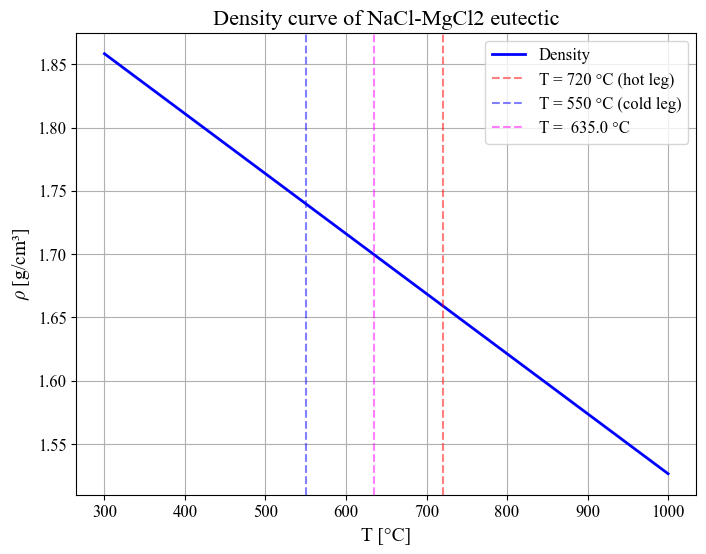

In [6]:
# Plot density curve
salt_density_plotter(T, rho, T_hot, T_cold)

In [10]:
# Mass of individual salt components and mixture (eut, mimosa..)
m_salt, salt_names, salt_masses = salt_mass_crucible(635, "eutectic")
m_salt, salt_names, salt_masses = salt_mass_crucible(635, "mimosa")

Using eutectic molar fractions to composition.
[37.09625392 62.90374608]
[49. 51.]
--------------------------------------------------

SALT LOADING QUANTITIES FOR CRUCIBLE:
Type: eutectic
Weight fractions (w%):


UnboundLocalError: cannot access local variable 'masses' where it is not associated with a value

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pint
import scipy
from scipy.interpolate import interp1d

# ---------- SETUP ---------- #
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

In [12]:
# 1. THE DATABASE
# Add any salt you ever want to use here. No more globals.
MOLAR_MASS_DB = {
    'NaCl':  58.44 * ureg('g/mol'),
    'MgCl2': 95.21 * ureg('g/mol'),
    'CeCl3': 246.48 * ureg('g/mol'),
    'KCl':   74.55 * ureg('g/mol'), 
    'ZnCl2': 136.315 * ureg('g/mol')
}

In [13]:
class SaltMixture:
    def __init__(self, name, composition, basis='weight', density_func=None):
        """
        name: str, e.g., "MIMOSA"
        composition: dict, e.g., {'NaCl': 40, 'MgCl2': 60}
        basis: 'weight' (w%) or 'molar' (mol%)
        density_func: a function that takes T (in Kelvin) and returns density (g/cm^3)
        """
        self.name = name
        self.density_func = density_func
        
        # Normalize composition to ensure it sums to 100% or 1.0
        total = sum(composition.values())
        norm_comp = {k: v/total for k, v in composition.items()}
        
        if basis == 'weight':
            self.mass_fractions = norm_comp
            self.molar_fractions = self._calculate_molar_fractions(norm_comp)
        elif basis == 'molar':
            self.molar_fractions = norm_comp
            self.mass_fractions = self._calculate_mass_fractions(norm_comp)
        else:
            raise ValueError("basis must be 'weight' or 'molar'")

    def _calculate_molar_fractions(self, mass_fracs):
        """Internal: Converts w% to mol%"""
        moles = {}
        for salt, w_frac in mass_fracs.items():
            mw = MOLAR_MASS_DB[salt].to('g/mol').magnitude
            moles[salt] = w_frac / mw
        
        total_moles = sum(moles.values())
        return {k: (v / total_moles) for k, v in moles.items()}

    def _calculate_mass_fractions(self, molar_fracs):
        """Internal: Converts mol% to w%"""
        weights = {}
        for salt, mol_frac in molar_fracs.items():
            mw = MOLAR_MASS_DB[salt].to('g/mol').magnitude
            weights[salt] = mol_frac * mw
            
        total_weight = sum(weights.values())
        return {k: (v / total_weight) for k, v in weights.items()}

    def get_density(self, T):
        """Get density at specific Temperature (pint Quantity)"""
        if self.density_func is None:
            raise ValueError(f"No density function defined for {self.name}")
        
        # Ensure T is in Kelvin for the math
        T_kelvin = T.to('K').magnitude
        rho = self.density_func(T_kelvin)
        return Q_(rho, 'g/cm^3')

    def calculate_crucible_loading(self, T, height=75, radius=7):
        """
        Calculates how much of each component to add.
        T: Temperature (pint Quantity)
        height: mm
        radius: mm
        """
        # 1. Calculate Volume
        h = Q_(height, 'mm')
        r = Q_(radius, 'mm')
        volume = (np.pi * r**2 * h).to('cm^3')

        # 2. Get Density and Total Mass
        rho = self.get_density(T)
        total_mass = rho * volume

        # 3. Calculate individual component masses
        loading_plan = {}
        for salt, w_frac in self.mass_fractions.items():
            loading_plan[salt] = total_mass * w_frac

        return total_mass, loading_plan

    def print_report(self, T_target):
        """Pretty prints the salt info similar to your original script"""
        print("-" * 50)
        print(f"REPORT FOR: {self.name}")
        print(f"Target Temp: {T_target}")
        
        try:
            rho = self.get_density(T_target)
            print(f"Density: {rho:.4f}")
        except:
            print("Density: Undefined function")

        print("\n--- Composition ---")
        print(f"{'Component':<10} | {'Mass %':<10} | {'Mol %':<10}")
        for salt in self.mass_fractions:
            w_p = self.mass_fractions[salt] * 100
            m_p = self.molar_fractions[salt] * 100
            print(f"{salt:<10} | {w_p:.2f}%      | {m_p:.2f}%")
        print("-" * 50)

In [14]:
# ---------- IMPLEMENTING YOUR SALTS ---------- #

# 1. Define the Eutectic Density Function (Linear: a - bT)
def eutectic_density(T_kelvin):
    # a and b for NaCl-MgCl2 Eutectic
    a = 2.13 # 
    b = 4.74*10**(-4) 
    return a - (b * T_kelvin)

# 2. Define the MIMOSA Density Function (Interpolation)
def mimosa_density_builder(rho1, T1_C, rho2, T2_C):
    # Create a linear interpolation function
    temps = [Q_(T1_C, 'degC').to('K').magnitude, Q_(T2_C, 'degC').to('K').magnitude]
    rhos = [rho1, rho2]
    interpolator = interp1d(temps, rhos, fill_value="extrapolate")
    return interpolator


In [19]:
# ---------- USAGE EXAMPLES ---------- #

# Example 1: NaCl-MgCl2 Eutectic
# You define it once, and it calculates fractions automatically
eutectic_salt = SaltMixture(
    name="NaCl-MgCl2 Eutectic",
    composition={'NaCl':49.77, 'MgCl2': 50.23}, # Assumed weight %
    basis='weight',
    density_func=eutectic_density
)

# Example 2: MIMOSA
# Creating the density function dynamically
mimosa_func = mimosa_density_builder(2.53, 600, 2.47, 700) # Data densities since no a and b.

mimosa_salt = SaltMixture(
    name="MIMOSA",
    composition={'NaCl': 56.76, 'MgCl2': 35.16, 'CeCl3': 8.08}, # Assumed mol %
    basis='molar', 
    density_func=mimosa_func
)

# ---------- RUNNING CALCULATIONS ---------- #

# Report on Eutectic at 635C
eutectic_salt.print_report(Q_(635, 'degC'))
total_mass, recipe = eutectic_salt.calculate_crucible_loading(Q_(635, 'degC'), height=75, radius=7)

print(f"\nLoading Recipe for {eutectic_salt.name} at {Q_(635, 'degC')}:")
print(f"Total Mass Required: {total_mass:.2f}")
for ingredient, amount in recipe.items():
    print(f" - {ingredient}: {amount:.2f}")

# Report on MIMOSA at 635C
mimosa_salt.print_report(Q_(635, 'degC'))
total_mass, recipe = mimosa_salt.calculate_crucible_loading(Q_(635, 'degC'), height=75, radius=7)

print(f"\nLoading Recipe for {mimosa_salt.name} at {Q_(635, 'degC')}:")
print(f"Total Mass Required: {total_mass:.2f}")
for ingredient, amount in recipe.items():
    print(f" - {ingredient}: {amount:.2f}")

--------------------------------------------------
REPORT FOR: NaCl-MgCl2 Eutectic
Target Temp: 635 degree_Celsius
Density: 1.6995 gram / centimeter ** 3

--- Composition ---
Component  | Mass %     | Mol %     
NaCl       | 49.77%      | 61.75%
MgCl2      | 50.23%      | 38.25%
--------------------------------------------------

Loading Recipe for NaCl-MgCl2 Eutectic at 635 degree_Celsius:
Total Mass Required: 19.62 gram
 - NaCl: 9.77 gram
 - MgCl2: 9.86 gram
--------------------------------------------------
REPORT FOR: MIMOSA
Target Temp: 635 degree_Celsius
Density: 2.5090 gram / centimeter ** 3

--- Composition ---
Component  | Mass %     | Mol %     
NaCl       | 38.32%      | 56.76%
MgCl2      | 38.67%      | 35.16%
CeCl3      | 23.01%      | 8.08%
--------------------------------------------------

Loading Recipe for MIMOSA at 635 degree_Celsius:
Total Mass Required: 28.97 gram
 - NaCl: 11.10 gram
 - MgCl2: 11.20 gram
 - CeCl3: 6.66 gram
